<a href="https://colab.research.google.com/github/Shashikalayh/AllProjectsShashi/blob/main/CNN_class10_ResNet18_34_VGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Class10: Hyperparameter Tuning for ResNet‑18, ResNet‑34, VGG‑19

This notebook extends the basic training workflow by introducing **additional hyperparameter tuning**. It trains and validates on your **train** and **val** splits, allowing flexible selection of optimizers, schedulers, data augmentation (Mixup/CutMix), label smoothing, weight decay, exponential moving average (EMA), early stopping, and gradient clipping. After tuning, you can upload the **test** ZIP to run a final evaluation.

**Workflow:**
1. Upload your **train** and **val** ZIPs to `/content/` (filenames must include `train` and `val` / `valid` / `validation`).
2. Unzip the datasets and prepare DataLoaders.
3. Choose a configuration (or define your own) for each model. The `train_with_config` helper handles training with advanced options.
4. Compare results across hyperparameters.
5. After tuning, upload your **test** ZIP and run the evaluation cell to report test accuracy.


In [ ]:

#@title 0) Setup
!pip -q install torchmetrics==1.4.0 --quiet

import os, glob, zipfile, math, re, random, shutil
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from PIL import Image

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print('torch:', torch.__version__, '| torchvision:', torchvision.__version__)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 18.0 MB/s eta 0:00:00
Using device: cuda
torch: 2.6.0+cu124

In [ ]:

#@title 1) Unzip train & val ZIPs (test later)
ROOT = Path('/content/dataset_root')
for split in ['train','val']:
    (ROOT/split).mkdir(parents=True, exist_ok=True)

# pick zip file based on keywords
def pick_zip(keywords):
    cands = []
    for z in glob.glob('/content/*.zip'):
        name = os.path.basename(z).lower()
        if any(k in name for k in keywords):
            cands.append(z)
    cands = sorted(cands, key=os.path.getsize, reverse=True)
    return cands[0] if cands else None

train_zip = pick_zip(['train'])
val_zip   = pick_zip(['val','valid','validation'])

if not train_zip or not val_zip:
    raise SystemExit("Missing train or val zip. Ensure filenames include 'train' and 'val' (or 'valid'/'validation').")

print('Found train zip:', train_zip)
print('Found val zip  :', val_zip)

# extract
for split, zip_path in [('train', train_zip), ('val', val_zip)]:
    with zipfile.ZipFile(zip_path, 'r') as zf:
        zf.extractall(ROOT/split)
    # unwrap if single folder
    split_dir = ROOT/split
    items = [p for p in split_dir.iterdir() if p.name not in ('__MACOSX',)]
    if len(items) == 1 and items[0].is_dir():
        inner = items[0]
        for p in inner.iterdir():
            shutil.move(str(p), str(split_dir / p.name))
        shutil.rmtree(inner, ignore_errors=True)

print('Dataset prepared in', ROOT)


Found train zip: /content/train.zip
Found val zip  : /content/val.zip
Dataset prepared in /content/dataset_root


In [ ]:

#@title 2) Build DataLoaders (train/val)
IMNET_MEAN = [0.485, 0.456, 0.406]
IMNET_STD  = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(IMNET_MEAN, IMNET_STD),
])

eval_tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMNET_MEAN, IMNET_STD),
])

train_dir = (ROOT/'train').resolve()
val_dir   = (ROOT/'val').resolve()

# Mode: True = ImageFolder; False = flat filename labels 0..9
USE_IMAGEFOLDER = True
FILENAME_LABEL_REGEX = r'(\d{1,2})'

class FlatLabelDataset(Dataset):
    def __init__(self, root, tfm, label_regex=FILENAME_LABEL_REGEX):
        self.root = Path(root)
        exts = {'.jpg','.jpeg','.png','.bmp','.webp'}
        self.paths = [p for p in self.root.glob('**/*') if p.suffix.lower() in exts]
        self.tfm = tfm
        self.pattern = re.compile(label_regex)
        self.labels = []
        for p in self.paths:
            m = self.pattern.search(p.name)
            if not m: raise ValueError(f'No label in filename: {p.name}')
            y = int(m.group(1))
            if not (0 <= y <= 9): raise ValueError(f'Label out of range 0-9: {p.name}')
            self.labels.append(y)
        self.class_names = [str(i) for i in range(10)]
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('RGB')
        return self.tfm(img), self.labels[idx]

# loader builders
def loaders_imagefolder(batch=32, workers=2):
    train_ds = datasets.ImageFolder(train_dir, train_tfms)
    val_ds   = datasets.ImageFolder(val_dir,   eval_tfms)
    class_names = train_ds.classes
    return class_names, DataLoader(train_ds, batch, True,  num_workers=workers, pin_memory=True),                         DataLoader(val_ds,   batch, False, num_workers=workers, pin_memory=True)

def loaders_flat(batch=32, workers=2):
    train_ds = FlatLabelDataset(train_dir, train_tfms)
    val_ds   = FlatLabelDataset(val_dir,   eval_tfms)
    class_names = train_ds.class_names
    return class_names, DataLoader(train_ds, batch, True,  num_workers=workers, pin_memory=True),                         DataLoader(val_ds,   batch, False, num_workers=workers, pin_memory=True)

if USE_IMAGEFOLDER:
    class_names, train_loader, val_loader = loaders_imagefolder()
else:
    class_names, train_loader, val_loader = loaders_flat()

num_classes = 10
print('Classes:', class_names)
print('Num classes =', num_classes)

# quick batch sanity
xb, yb = next(iter(train_loader))
print('Train batch shape:', xb.shape, '| labels sample:', yb[:10].tolist())


Classes: ['n02787622', 'n02804610', 'n02870880', 'n02992211', 'n03452741', 'n03495258', 'n03642806', 'n03721384', 'n03759954', 'n04311174']
Num classes = 10
Train batch shape: torch.Size([32, 3, 224, 224]) | labels sample: [3, 9, 8, 0, 2, 7, 4, 4, 3, 5]


In [ ]:

#@title 3) Utilities: evaluate, plot_confusion, per_class_accuracy
import numpy as np
from sklearn.metrics import confusion_matrix
import torch

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    losses, correct, total = [], 0, 0
    y_true, y_pred = [], []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        losses.append(loss.item())
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)
        y_true.extend(y.cpu().tolist())
        y_pred.extend(preds.cpu().tolist())
    return float(np.mean(losses)), correct / max(1, total), np.array(y_true), np.array(y_pred)


def plot_confusion(y_true, y_pred, class_names, normalize=True, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True).clip(min=1)
    plt.figure(figsize=(7,6))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names, rotation=45, ha='right')
    plt.yticks(ticks, class_names)
    plt.tight_layout()
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.show()


def per_class_accuracy(y_true, y_pred, class_names):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    for idx, name in enumerate(class_names):
        mask = (y_true == idx)
        denom = mask.sum()
        acc = (y_pred[mask] == y_true[mask]).sum() / denom if denom else 0.0
        print(f'{name:>20s}: {acc*100:.2f}% (n={denom})')


## Experiment Setup (Class10)

Below is an outline of the dataset processing, model architecture modifications, and hyperparameters used for tuning. Fill in any additional notes or adjustments you make.

**Data**
- **Training augmentations:** `Resize(256)` → `RandomResizedCrop(224)` → `RandomHorizontalFlip(p=0.5)` → `ToTensor()` → **Normalize(ImageNet)** (mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]).
- **Validation/Test preprocessing:** `Resize(256)` → `CenterCrop(224)` → `ToTensor()` → Normalize(ImageNet).
- **Batch size:** 32  •  **Num workers:** 2

**Models**
- **ResNet-18 / ResNet-34:** Pretrained weights loaded (`ResNet18_Weights.DEFAULT`, `ResNet34_Weights.DEFAULT`). Final fully-connected layer (`m.fc`) replaced with a new `nn.Linear` layer with 10 outputs.
- **VGG-19:** Pretrained weights loaded (`VGG19_Weights.DEFAULT`). Final linear layer in the classifier head replaced with a new `nn.Linear` layer with 10 outputs.

**Hyperparameters**
- **ResNet-18**
  - Epochs: 15
  - Learning rate (LR): 3e-4
  - Weight decay (WD): 1e-4
  - Optimizer: **AdamW**
  - Scheduler: **OneCycleLR** with max LR = 3e-4
  - Label smoothing: 0.05
  - Mixup/CutMix: disabled
  - Early stopping: patience = 3, delta = 0.0
  - EMA / Gradient clipping: disabled

- **ResNet-34**
  - Epochs: 20
  - LR: 2e-3
  - WD: 5e-4
  - Optimizer: **SGD** with momentum and Nesterov
  - Scheduler: **StepLR** with step_size = 6, gamma = 0.5
  - Mixup: α = 0.2 (applied half the time; CutMix disabled)
  - Label smoothing: 0.0
  - Early stopping: patience = 5, delta = 0.0

- **VGG-19**
  - Epochs: 25
  - LR: 1e-4
  - WD: 1e-4
  - Optimizer: **Adam**
  - Scheduler: **CosineAnnealingLR** with `T_max = 25`
  - Label smoothing: 0.1
  - Mixup/CutMix: disabled
  - Freeze epochs: 3 (only classifier layers updated initially)
  - EMA: decay = 0.999
  - Gradient clipping: 1.0
  - Early stopping: patience = 4, delta = 0.0

**Notes**
- You can modify these values or define new configuration dictionaries for further experiments.
- The `train_with_config` function orchestrates the optimizer, scheduler, augmentation, EMA, gradient clipping, and early stopping based on the provided config.
- Best checkpoints (`*_best.pth`) are saved under `/content/` during training. A summary JSON and a ZIP for submission will be created in later steps.

In [ ]:

#@title 4) Advanced training helpers: Mixup/CutMix, EMA, EarlyStopping, Grad Clip
import copy
from dataclasses import dataclass

# Beta sampling helper
def _rand_beta(alpha, size):
    if alpha <= 0: return [1.0] * size
    return torch.distributions.Beta(alpha, alpha).sample((size,)).tolist()

# Mixup/CutMix augmentation
def apply_mixup_cutmix(x, y, num_classes, mixup_alpha=0.0, cutmix_alpha=0.0):
    B = x.size(0)
    if mixup_alpha <= 0 and cutmix_alpha <= 0:
        # return one-hot targets for compatibility with label smoothing
        y_oh = torch.zeros(B, num_classes, device=x.device)
        y_oh.scatter_(1, y.view(-1,1), 1.0)
        return x, y_oh, 1.0, y
    use_cutmix = (cutmix_alpha > 0) and (torch.rand(1).item() < 0.5)
    lam = _rand_beta(cutmix_alpha if use_cutmix else mixup_alpha, 1)[0]
    perm = torch.randperm(B, device=x.device)
    x2, y2 = x[perm], y[perm]
    if use_cutmix:
        H, W = x.size(2), x.size(3)
        cx, cy = torch.randint(W, (1,), device=x.device), torch.randint(H, (1,), device=x.device)
        rw = int(W * math.sqrt(1 - lam))
        rh = int(H * math.sqrt(1 - lam))
        x1, y1 = max(cx - rw//2, 0), max(cy - rh//2, 0)
        x2b, y2b = min(cx + rw//2, W), min(cy + rh//2, H)
        x[:, :, y1:y2b, x1:x2b] = x2[:, :, y1:y2b, x1:x2b]
        lam = 1 - ((x2b - x1) * (y2b - y1) / (W * H))
    # build soft targets
    y_oh = torch.zeros(B, num_classes, device=x.device)
    y2_oh = torch.zeros(B, num_classes, device=x.device)
    y_oh.scatter_(1, y.view(-1,1), 1.0)
    y2_oh.scatter_(1, y2.view(-1,1), 1.0)
    if not use_cutmix:
        x = lam * x + (1 - lam) * x2
    y_soft = lam * y_oh + (1 - lam) * y2_oh
    return x, y_soft, lam, y

# EMA helper
class ModelEMA:
    def __init__(self, model, decay=0.999):
        self.ema = copy.deepcopy(model).eval()
        for p in self.ema.parameters(): p.requires_grad_(False)
        self.decay = decay
    @torch.no_grad()
    def update(self, model):
        msd, esd = model.state_dict(), self.ema.state_dict()
        for k in esd.keys():
            if esd[k].dtype.is_floating_point:
                esd[k].mul_(self.decay).add_(msd[k], alpha=1 - self.decay)
            else:
                esd[k] = msd[k]

# Early stopping
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        self.best = -1.0
        self.patience = patience
        self.min_delta = min_delta
        self.wait = 0
        self.should_stop = False
    def step(self, val_acc):
        if val_acc > self.best + self.min_delta:
            self.best = val_acc
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.should_stop = True



In [ ]:

#@title 5) Config-driven training function
from torch.optim import AdamW, Adam, SGD
from torch.optim.lr_scheduler import OneCycleLR, StepLR, CosineAnnealingLR, ReduceLROnPlateau

# Build optimizer

def build_optimizer(model, cfg):
    name = cfg.get('opt', 'AdamW').lower()
    lr = cfg.get('lr', 3e-4)
    wd = cfg.get('wd', 1e-4)
    if name == 'sgd':
        return SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True, weight_decay=wd)
    if name == 'adam':
        return Adam(model.parameters(), lr=lr, weight_decay=wd)
    return AdamW(model.parameters(), lr=lr, weight_decay=wd)

# Build scheduler

def build_scheduler(optimizer, cfg, steps_per_epoch):
    sch = cfg.get('sched', 'onecycle').lower()
    epochs = cfg['epochs']
    if sch == 'step':
        return StepLR(optimizer, step_size=cfg.get('step_size', 5), gamma=cfg.get('gamma', 0.5))
    if sch == 'cosine':
        return CosineAnnealingLR(optimizer, T_max=cfg.get('T_max', epochs))
    if sch == 'plateau':
        return ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    return OneCycleLR(optimizer, max_lr=cfg['lr'], steps_per_epoch=steps_per_epoch, epochs=epochs)

# Freeze/unfreeze helpers

def maybe_freeze(model, freeze=True):
    if freeze:
        for p in model.parameters():
            p.requires_grad = False

def unfreeze(model):
    for p in model.parameters(): p.requires_grad = True

# Main training function with config

def train_with_config(model, model_tag, cfg, train_loader, val_loader, num_classes, class_names):
    device = next(model.parameters()).device
    epochs = cfg['epochs']
    label_smooth = cfg.get('label_smoothing', 0.0)
    mixup_alpha = cfg.get('mixup_alpha', 0.0)
    cutmix_alpha = cfg.get('cutmix_alpha', 0.0)
    use_ema = cfg.get('ema', False)
    grad_clip = cfg.get('grad_clip', 0.0)
    freeze_epochs = cfg.get('freeze_epochs', 0)
    early = EarlyStopping(patience=cfg.get('early_patience', 0), min_delta=cfg.get('early_delta', 0.0))

    # Freeze backbone initially
    if freeze_epochs > 0:
        maybe_freeze(model, True)
        # Unfreeze classifier/head only
        if hasattr(model, 'fc'):
            for p in model.fc.parameters(): p.requires_grad = True
        elif hasattr(model, 'classifier'):
            for p in model.classifier.parameters(): p.requires_grad = True

    criterion = nn.CrossEntropyLoss(label_smoothing=label_smooth)
    optimizer = build_optimizer(model, cfg)
    steps_per_epoch = max(1, math.ceil(len(train_loader.dataset)/train_loader.batch_size))
    scheduler = build_scheduler(optimizer, cfg, steps_per_epoch)
    scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))

    ema = ModelEMA(model, decay=cfg.get('ema_decay', 0.999)) if use_ema else None

    best_acc, best_path = 0.0, f'/content/{model_tag}_best.pth'
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for ep in range(1, epochs+1):
        # Unfreeze whole model after freeze_epochs
        if ep == freeze_epochs + 1 and freeze_epochs > 0:
            unfreeze(model)
            optimizer = build_optimizer(model, cfg)

        model.train()
        tr_losses, tr_correct, tr_total = [], 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):
                if mixup_alpha > 0 or cutmix_alpha > 0:
                    x_aug, y_soft, lam, y_hard = apply_mixup_cutmix(x, y, num_classes, mixup_alpha, cutmix_alpha)
                    logits = model(x_aug)
                    log_probs = torch.log_softmax(logits, dim=1)
                    loss = -(y_soft * log_probs).sum(dim=1).mean()
                    preds = logits.argmax(1)
                    tr_correct += (preds == y_hard).sum().item()
                else:
                    logits = model(x)
                    loss = criterion(logits, y)
                    preds = logits.argmax(1)
                    tr_correct += (preds == y).sum().item()
            scaler.scale(loss).backward()
            if grad_clip > 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            scaler.step(optimizer)
            scaler.update()
            tr_losses.append(loss.item())
            tr_total += y.size(0)

        # scheduler step
        if isinstance(scheduler, OneCycleLR):
            scheduler.step()

        # validation
        vl_loss, vl_acc, y_true, y_pred = evaluate(model, val_loader, criterion)
        if isinstance(scheduler, (StepLR, CosineAnnealingLR)):
            scheduler.step()
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(vl_loss)

        # EMA update after each epoch
        if ema:
            ema.update(model)

        # record history
        tr_loss = float(np.mean(tr_losses))
        tr_acc = tr_correct / max(1, tr_total)
        history['train_loss'].append(tr_loss)
        history['train_acc'].append(tr_acc)
        history['val_loss'].append(vl_loss)
        history['val_acc'].append(vl_acc)

        print(f'Epoch {ep:02d}/{epochs} | train_loss={tr_loss:.4f} acc={tr_acc:.4f} | val_loss={vl_loss:.4f} acc={vl_acc:.4f}')

        if vl_acc > best_acc:
            best_acc = vl_acc
            torch.save({'model_state': model.state_dict(), 'classes': class_names, 'img_size': (224,224)}, best_path)
            print(f'  ↳ New best! Saved: {best_path} (val_acc={best_acc:.4f})')

        if early.patience > 0:
            early.step(vl_acc)
            if early.should_stop:
                print('Early stopping triggered.')
                break

    print(f'Best checkpoint for {model_tag}: {best_path} (val_acc={best_acc:.4f})')
    return best_path, history


In [ ]:

#@title 6) Model definitions (ResNet-18, ResNet-34, VGG-19)
from torchvision.models import (
    resnet18, ResNet18_Weights,
    resnet34, ResNet34_Weights,
    vgg19, VGG19_Weights
)

def make_resnet18(num_classes=10):
    m = resnet18(weights=ResNet18_Weights.DEFAULT)
    for p in m.parameters(): p.requires_grad = True
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

def make_resnet34(num_classes=10):
    m = resnet34(weights=ResNet34_Weights.DEFAULT)
    for p in m.parameters(): p.requires_grad = True
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

def make_vgg19(num_classes=10):
    m = vgg19(weights=VGG19_Weights.DEFAULT)
    for p in m.features.parameters(): p.requires_grad = True
    # replace last linear
    if isinstance(m.classifier[-1], nn.Linear):
        in_features = m.classifier[-1].in_features
        m.classifier[-1] = nn.Linear(in_features, num_classes)
    else:
        for i in range(len(m.classifier)-1, -1, -1):
            if isinstance(m.classifier[i], nn.Linear):
                in_features = m.classifier[i].in_features
                m.classifier[i] = nn.Linear(in_features, num_classes)
                break
    return m


In [ ]:

#@title 7) Example hyperparameter configs and training
# Define per-model hyperparameter configurations
cfg_r18 = dict(
    epochs=15, lr=3e-4, wd=1e-4,
    opt='AdamW', sched='onecycle',
    label_smoothing=0.05,
    mixup_alpha=0.0, cutmix_alpha=0.0,
    ema=False, grad_clip=0.0,
    early_patience=3, early_delta=0.0,
)

cfg_r34 = dict(
    epochs=20, lr=2e-3, wd=5e-4,
    opt='SGD', sched='step', step_size=6, gamma=0.5,
    label_smoothing=0.0,
    mixup_alpha=0.2, cutmix_alpha=0.0,
    ema=False, grad_clip=0.0,
    early_patience=5, early_delta=0.0,
)

cfg_vgg = dict(
    epochs=25, lr=1e-4, wd=1e-4,
    opt='Adam', sched='cosine', T_max=25,
    label_smoothing=0.1,
    mixup_alpha=0.0, cutmix_alpha=0.0,
    freeze_epochs=3,
    ema=True, ema_decay=0.999,
    grad_clip=1.0,
    early_patience=4, early_delta=0.0,
)

# Train each model with its config
path_r18, hist_r18 = train_with_config(make_resnet18(10).to(device), 'ResNet18', cfg_r18, train_loader, val_loader, 10, class_names)
path_r34, hist_r34 = train_with_config(make_resnet34(10).to(device), 'ResNet34', cfg_r34, train_loader, val_loader, 10, class_names)
path_vgg, hist_vgg = train_with_config(make_vgg19(10).to(device),    'VGG19',    cfg_vgg, train_loader, val_loader, 10, class_names)

print('\nBest checkpoints:')
print(' ResNet18:', path_r18)
print(' ResNet34:', path_r34)
print(' VGG19   :', path_vgg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:02<00:00, 20.3MB/s]
/tmp/ipython-input-961011801.py:66: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))
/tmp/ipython-input-961011801.py:84: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):


Epoch 01/15 | train_loss=1.0716 acc=0.7607 | val_loss=0.6143 acc=0.9220
  ↳ New best! Saved: /content/ResNet18_best.pth (val_acc=0.9220)
Epoch 02/15 | train_loss=0.5908 acc=0.9146 | val_loss=0.5286 acc=0.9360
  ↳ New best! Saved: /content/ResNet18_best.pth (val_acc=0.9360)
Epoch 03/15 | train_loss=0.5107 acc=0.9367 | val_loss=0.4899 acc=0.9420
  ↳ New best! Saved: /content/ResNet18_best.pth (val_acc=0.9420)
Epoch 04/15 | train_loss=0.4667 acc=0.9522 | val_loss=0.4744 acc=0.9540
  ↳ New best! Saved: /content/ResNet18_best.pth (val_acc=0.9540)
Epoch 05/15 | train_loss=0.4345 acc=0.9658 | val_loss=0.4688 acc=0.9560
  ↳ New best! Saved: /content/ResNet18_best.pth (val_acc=0.9560)
Epoch 06/15 | train_loss=0.4126 acc=0.9743 | val_loss=0.4597 acc=0.9500
Epoch 07/15 | train_loss=0.3915 acc=0.9811 | val_loss=0.4575 acc=0.9580
  ↳ New best! Saved: /content/ResNet18_best.pth (val_acc=0.9580)
Epoch 08/15 | train_loss=0.3788 acc=0.9855 | val_loss=0.4552 acc=0.9540
Epoch 09/15 | train_loss=0.3668 ac

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:04<00:00, 20.4MB/s]


Epoch 01/20 | train_loss=0.7565 acc=0.5098 | val_loss=0.2190 acc=0.9380
  ↳ New best! Saved: /content/ResNet34_best.pth (val_acc=0.9380)
Epoch 02/20 | train_loss=0.6065 acc=0.4858 | val_loss=0.1656 acc=0.9580
  ↳ New best! Saved: /content/ResNet34_best.pth (val_acc=0.9580)
Epoch 03/20 | train_loss=0.5488 acc=0.5566 | val_loss=0.1717 acc=0.9500
Epoch 04/20 | train_loss=0.5138 acc=0.5617 | val_loss=0.1530 acc=0.9560
Epoch 05/20 | train_loss=0.5265 acc=0.5377 | val_loss=0.2026 acc=0.9440
Epoch 06/20 | train_loss=0.4970 acc=0.5597 | val_loss=0.1601 acc=0.9540
Epoch 07/20 | train_loss=0.4112 acc=0.5732 | val_loss=0.1446 acc=0.9600
  ↳ New best! Saved: /content/ResNet34_best.pth (val_acc=0.9600)
Epoch 08/20 | train_loss=0.4881 acc=0.5667 | val_loss=0.1783 acc=0.9540
Epoch 09/20 | train_loss=0.4148 acc=0.5741 | val_loss=0.1641 acc=0.9620
  ↳ New best! Saved: /content/ResNet34_best.pth (val_acc=0.9620)
Epoch 10/20 | train_loss=0.4396 acc=0.5531 | val_loss=0.2067 acc=0.9520
Epoch 11/20 | train_

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:29<00:00, 19.3MB/s]


Epoch 01/25 | train_loss=0.7928 acc=0.9131 | val_loss=0.6549 acc=0.9580
  ↳ New best! Saved: /content/VGG19_best.pth (val_acc=0.9580)
Epoch 02/25 | train_loss=0.6686 acc=0.9602 | val_loss=0.6564 acc=0.9620
  ↳ New best! Saved: /content/VGG19_best.pth (val_acc=0.9620)
Epoch 03/25 | train_loss=0.6295 acc=0.9751 | val_loss=0.6454 acc=0.9580
Epoch 04/25 | train_loss=0.7566 acc=0.9110 | val_loss=0.7497 acc=0.9200
Epoch 05/25 | train_loss=0.6933 acc=0.9354 | val_loss=0.7709 acc=0.9100
Epoch 06/25 | train_loss=0.6483 acc=0.9512 | val_loss=0.7637 acc=0.8980
Early stopping triggered.
Best checkpoint for VGG19: /content/VGG19_best.pth (val_acc=0.9620)

Best checkpoints:
 ResNet18: /content/ResNet18_best.pth
 ResNet34: /content/ResNet34_best.pth
 VGG19   : /content/VGG19_best.pth


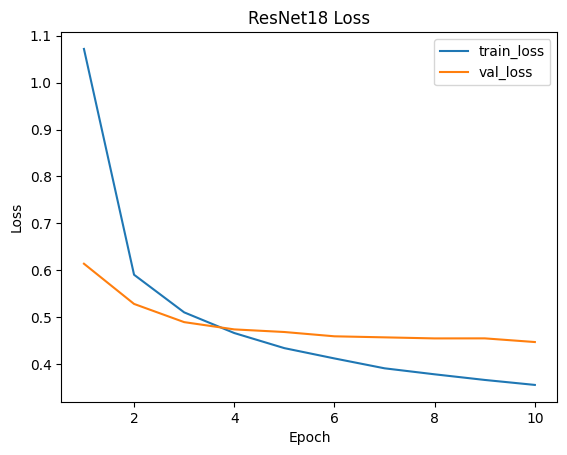

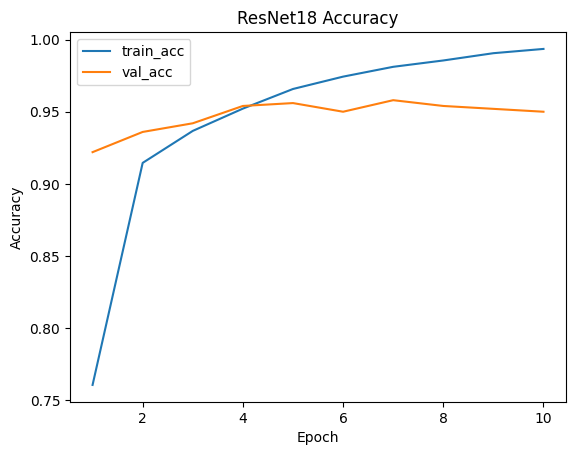

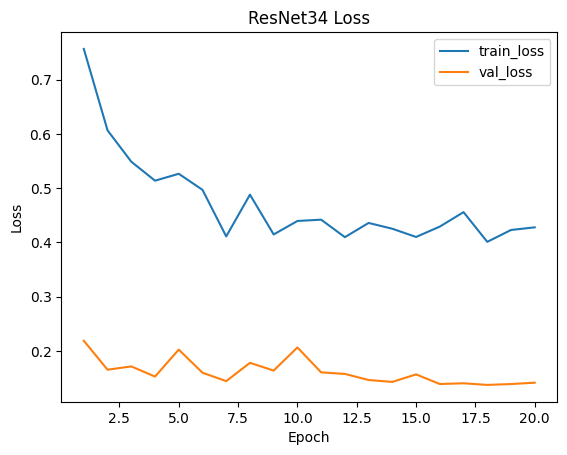

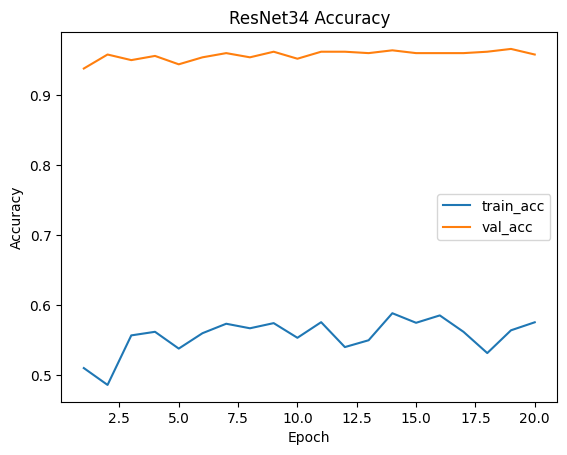

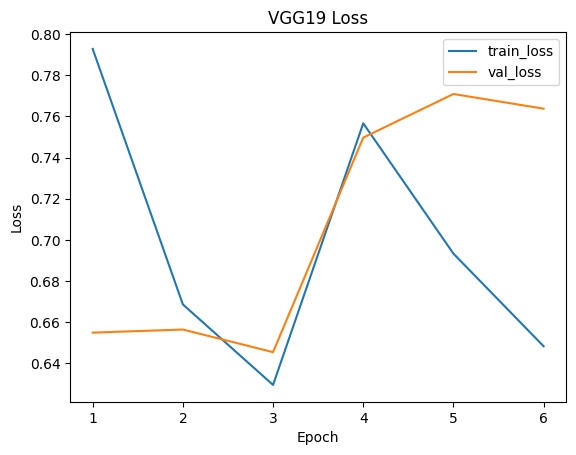

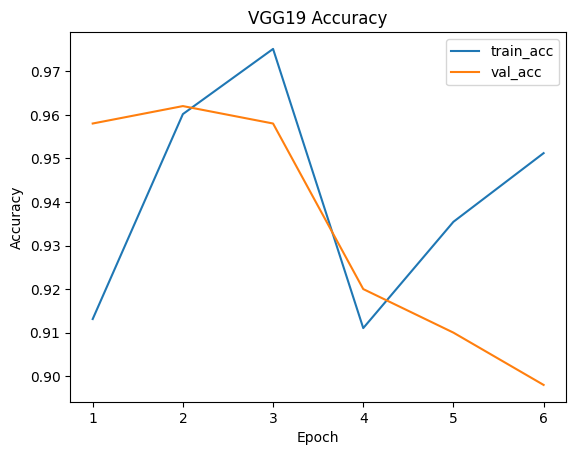

In [ ]:
import matplotlib.pyplot as plt

def plot_history(hist, name):
    epochs = range(1, len(hist['train_loss']) + 1)
    # Loss curve
    plt.figure()
    plt.plot(epochs, hist['train_loss'], label='train_loss')
    plt.plot(epochs, hist['val_loss'], label='val_loss')
    plt.title(f'{name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    # Accuracy curve
    plt.figure()
    plt.plot(epochs, hist['train_acc'], label='train_acc')
    plt.plot(epochs, hist['val_acc'], label='val_acc')
    plt.title(f'{name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Example: plot curves for each trained model
for model_name, history in [('ResNet18', hist_r18), ('ResNet34', hist_r34), ('VGG19', hist_vgg)]:
    plot_history(history, model_name)


Validation confusion matrix for ResNet-18:


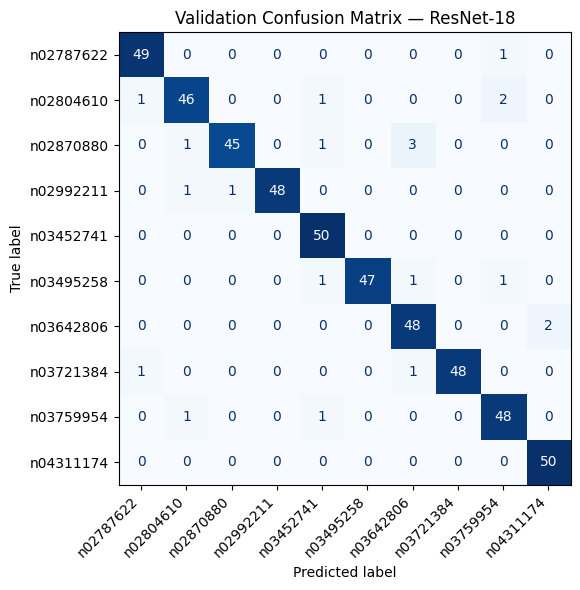

Validation confusion matrix for ResNet-34:


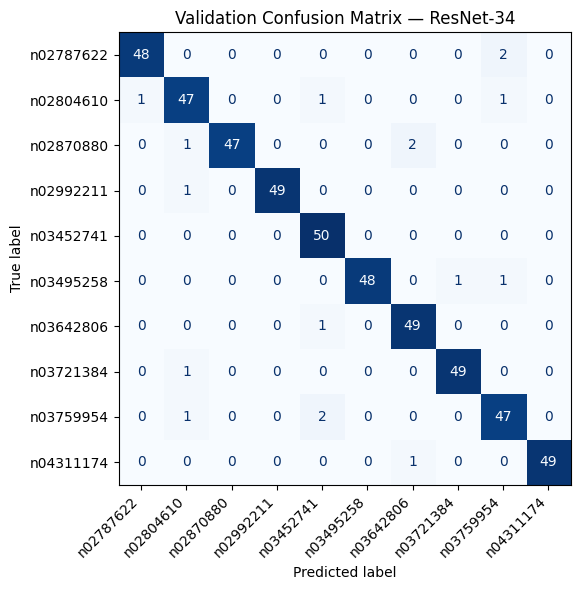

Validation confusion matrix for VGG-19:


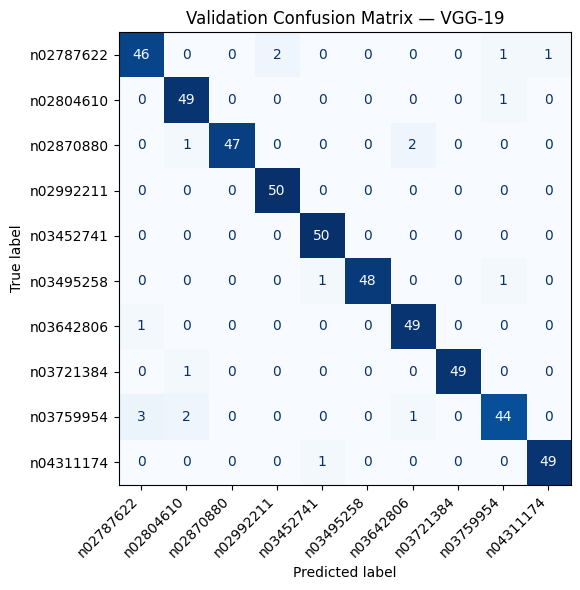

In [ ]:
#@title 10) Compute confusion matrix on validation set for each model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch

# Function to compute confusion matrix
def compute_confusion(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            preds = outputs.argmax(1)
            y_true.extend(yb.cpu().numpy().tolist())
            y_pred.extend(preds.cpu().numpy().tolist())
    return confusion_matrix(y_true, y_pred)

# Build and display confusion matrix on validation set for each trained model
for ckpt_path, make_model, name in [
    (path_r18, make_resnet18, 'ResNet-18'),
    (path_r34, make_resnet34, 'ResNet-34'),
    (path_vgg, make_vgg19, 'VGG-19'),
]:
    print(f"Validation confusion matrix for {name}:")
    # Load the checkpoint and model
    ckpt = torch.load(ckpt_path, map_location=device)
    model = make_model(10).to(device)
    model.load_state_dict(ckpt['model_state'])
    # Compute confusion matrix
    cm = compute_confusion(model, val_loader)
    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.set_yticklabels(class_names, rotation=0)
    ax.set_title(f'Validation Confusion Matrix — {name}')
    plt.tight_layout()
    plt.show()


In [ ]:
#@title 8a) Save summary and package .pth files
import json, time, os, zipfile

# Build summary using global variables from training runs
summary = {
    "timestamp": time.strftime("%Y-%m-%d_%H-%M-%S"),
    "class_names": class_names,
    "configs": {
        "ResNet18": cfg_r18,
        "ResNet34": cfg_r34,
        "VGG19"   : cfg_vgg
    },
    "checkpoints": {
        "ResNet18": path_r18,
        "ResNet34": path_r34,
        "VGG19"   : path_vgg
    },
    "val_best_acc": {
        "ResNet18": max(hist_r18["val_acc"]) if hist_r18["val_acc"] else None,
        "ResNet34": max(hist_r34["val_acc"]) if hist_r34["val_acc"] else None,
        "VGG19"   : max(hist_vgg["val_acc"]) if hist_vgg["val_acc"] else None
    }
}
# Write summary JSON
summary_path = '/content/experiment_summary.json'
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)
print('Summary written to', summary_path)

# Create submission zip containing the .pth files and summary JSON
SUBMIT_ZIP = '/content/submission_models_and_config.zip'
with zipfile.ZipFile(SUBMIT_ZIP, 'w', compression=zipfile.ZIP_DEFLATED) as z:
    for p in [path_r18, path_r34, path_vgg, summary_path]:
        if os.path.exists(p):
            z.write(p, arcname=os.path.basename(p))
        else:
            print('Warning: missing', p)
print('Created ZIP for submission:', SUBMIT_ZIP)

Summary written to /content/experiment_summary.json
Created ZIP for submission: /content/submission_models_and_config.zip


In [ ]:

#@title 8) After tuning, upload TEST zip and evaluate on test split
import os, glob, zipfile, shutil

(ROOT/'test').mkdir(parents=True, exist_ok=True)
# Clean test dir
for p in (ROOT/'test').glob('*'):
    if p.is_file(): p.unlink()
    elif p.is_dir(): shutil.rmtree(p, ignore_errors=True)

# Find test zip

def pick_zip(keywords):
    cands = []
    for z in glob.glob('/content/*.zip'):
        name = os.path.basename(z).lower()
        if any(k in name for k in keywords):
            cands.append(z)
    cands = sorted(cands, key=os.path.getsize, reverse=True)
    return cands[0] if cands else None

test_zip = pick_zip(['test'])
if not test_zip:
    raise SystemExit("No test ZIP found. Please upload a file containing 'test' in its name.")

print('Found test zip:', test_zip)
with zipfile.ZipFile(test_zip, 'r') as zf:
    zf.extractall(ROOT/'test')

# unwrap if single folder
items = [p for p in (ROOT/'test').iterdir() if p.name not in ('__MACOSX',)]
if len(items) == 1 and items[0].is_dir():
    inner = items[0]
    for p in inner.iterdir():
        shutil.move(str(p), str((ROOT/'test')/p.name))
    shutil.rmtree(inner, ignore_errors=True)

print('Test data extracted to', ROOT/'test')

# Build test loader consistent with training mode
if USE_IMAGEFOLDER:
    test_ds = datasets.ImageFolder((ROOT/'test').resolve(), eval_tfms)
    test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
    test_class_names = test_ds.classes
else:
    class FlatLabelDatasetTest(FlatLabelDataset):
        pass
    test_ds = FlatLabelDatasetTest((ROOT/'test').resolve(), eval_tfms)
    test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
    test_class_names = [str(i) for i in range(10)]

print('Test images:', len(test_loader.dataset))

# Evaluation on test set
@torch.no_grad()
def eval_ckpt(ckpt_path, model_fn, name):
    print(f'Evaluating {name} checkpoint: {ckpt_path}')
    ckpt = torch.load(ckpt_path, map_location=device)
    model = model_fn(10)
    model.load_state_dict(ckpt['model_state'])
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    tl, ta, y_true, y_pred = evaluate(model, test_loader, criterion)
    print(f'Test loss={tl:.4f}, Test acc={ta:.4f}')
    plot_confusion(y_true, y_pred, test_class_names, True, title=f'Test Confusion — {name}')

for ckpt_path, fn, name in [(f'/content/ResNet18_best.pth', make_resnet18, 'ResNet18'),
                           (f'/content/ResNet34_best.pth', make_resnet34, 'ResNet34'),
                           (f'/content/VGG19_best.pth',    make_vgg19,    'VGG19')]:
    if os.path.exists(ckpt_path):
        eval_ckpt(ckpt_path, fn, name)
    else:
        print('Checkpoint not found:', ckpt_path)
